# Preprocessing

In [1]:
# Face detection modules
from face_detection.face_parsing import FaceSegmentation
from face_detection.facenet_pytorch import MTCNN
from face_detection import FaceDetectionPipeline
# Other dependencies
from PIL import Image
import cv2
import numpy as np
import os
import pandas as pd
import random

#### Face detection and extraction

In [2]:
# Initialize models
mtcnn = MTCNN(keep_all=True, device="cuda")
segm = FaceSegmentation(device="cuda")

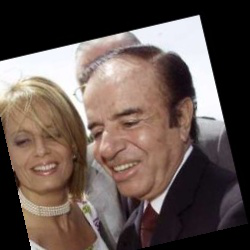

In [3]:
demo_image = Image.open("./data/lfw-py/lfw_funneled/Carlos_Menem/Carlos_Menem_0003.jpg")
demo_image

##### Face Segmentation

In [4]:
def masked_image(image: Image, segmentation_model: FaceSegmentation):
    EXCLUDE_LABELS = [0, 14, 17, 18]
    img_array = np.asarray(image)
    # Get segmentation labels
    labels = segmentation_model.get_mask(image)
    # Create mask
    mask = np.zeros(img_array.shape[:2], dtype=np.uint8)
    mask.fill(255)
    for v in EXCLUDE_LABELS:
        mask[labels == v] = 0
    masked_img = cv2.bitwise_and(img_array, img_array, mask=mask)
    return Image.fromarray(masked_img)

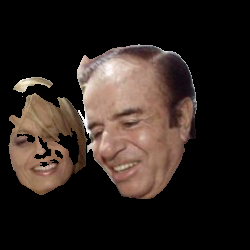

In [5]:
demo_masked = masked_image(demo_image, segm)
demo_masked

##### Face Bounding Box

In [6]:
def get_bounding_box(image: Image, mtcnn: MTCNN):
    def fit_box_to_image(box, image):
        x1, y1, x2, y2 = box
        x1, y1 = max(x1, 0), max(y1, 0)
        x2, y2 = min(x2, image.size[0]), min(y2, image.size[1])
        return x1, y1, x2, y2

    def get_box_size(box):
        return int((box[2] - box[0]) * (box[3] - box[1]))

    boxes, accs = mtcnn.detect(image)
    if len(boxes) == 0:
        x1, y1, x2, y2 = (0, 0) + image.size
    else:
        boxes = [fit_box_to_image(box, image) for box in boxes]
        detected = list(
            sorted(
                zip(boxes, accs),
                key=lambda x: (get_box_size(x[0]), float(x[1])),
                reverse=True,
            )
        )
        x1, y1, x2, y2 = (int(v) for v in detected[0][0])
    return ((x1, y1), (x2, y2))

In [7]:
def crop_to_box(image, box, resize=(224, 224)):
    img_array = np.asarray(image)
    (x1, y1), (x2, y2) = box
    cropped = img_array[y1:y2, x1:x2]
    cropped_image = Image.fromarray(cropped)
    cropped_image = cropped_image.resize(resize)
    return cropped_image

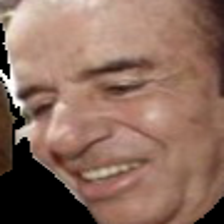

In [8]:
box = get_bounding_box(demo_image, mtcnn)
crop_to_box(demo_masked, box)

#### Final Pipeline

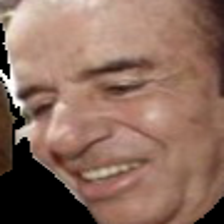

In [9]:
fd_pipeline = FaceDetectionPipeline("cuda")
fd_pipeline(demo_image)

#### Base dataset: Labeled Face in the Wild and Face-31

In [10]:
SOURCE_LFW = "./data/lfw-py"
SOURCE_F31 = "./data/face-31"
TARGET_DIR = "./data/processed"
os.makedirs(TARGET_DIR, exist_ok=True)
os.makedirs(os.path.join(TARGET_DIR, "train"), exist_ok=True)
os.makedirs(os.path.join(TARGET_DIR, "train/images"), exist_ok=True)
os.makedirs(os.path.join(TARGET_DIR, "test"), exist_ok=True)
os.makedirs(os.path.join(TARGET_DIR, "test/images"), exist_ok=True)

#### Merge and filter classes with low number of images

In [11]:
# Name - Count
lfw_names = dict()
f31_names = dict()

with open(os.path.join(SOURCE_LFW , "lfw-names.txt"), "r") as file:
    for line in file:
        name, count = line.strip().split()
        lfw_names[name] = int(count)

for dir_name in os.listdir(os.path.join(SOURCE_F31, "images")):
    name = dir_name.replace(" ", "_")
    count = len(os.listdir(os.path.join(os.path.join(SOURCE_F31, "images", dir_name))))
    f31_names[name] = count

print(f"LFW: {len(lfw_names)}, F31: {len(f31_names)}")

LFW: 5749, F31: 31


In [12]:
IMAGE_THRESHOLD = 10

combined_names = dict()
for name in sorted(lfw_names.keys() | f31_names.keys()):
    lfw_count = lfw_names.get(name, 0)
    f31_count = f31_names.get(name, 0)
    total_count = lfw_count + f31_count
    if total_count >= IMAGE_THRESHOLD:
        combined_names[name] = (lfw_count, f31_count)

num_classes = len(combined_names)
num_images = sum([lfw + f31 for lfw, f31 in combined_names.values()])
fwd_mapper = {i: name for i, name in enumerate(combined_names)}
inv_mapper = {name: i for i, name in enumerate(combined_names)}
print(f"""With image threshold of {IMAGE_THRESHOLD}:
- Number of classes: {num_classes}
- Number of images:  {num_images}""")

With image threshold of 10:
- Number of classes: 187
- Number of images:  6896


##### Train/Test folder

In [13]:
TRAIN_FRAC = 0.8
SEED = 315672
random.seed(SEED)

In [14]:
def get_image_paths(name: str, mapper: dict):
    image_idx = 0
    label = mapper[name]
    image_paths = []
    lfw_image_dir = os.path.join(SOURCE_LFW, "lfw_funneled", name)
    f31_image_dir = os.path.join(SOURCE_F31, "images", name.replace("_", " "))
    if os.path.isdir(lfw_image_dir):
        for image in os.listdir(lfw_image_dir):
            path = os.path.join(lfw_image_dir, image)
            save_path = f"{name}_{image_idx}.jpg"
            image_paths.append((path, save_path, label))
            image_idx += 1
    if os.path.isdir(f31_image_dir):
        for image in os.listdir(f31_image_dir):
            path = os.path.join(f31_image_dir, image)
            save_path = f"{name}_{image_idx}.jpg"
            image_paths.append((path, save_path, label))
            image_idx += 1
    return image_paths

In [15]:
train_images = []
test_images = []
mapping_file = os.path.join(TARGET_DIR, "mapping.csv")
pd.DataFrame(fwd_mapper.items(), columns=["Target", "Name"]).to_csv(mapping_file, index=False)
for target, name in fwd_mapper.items():
    images = get_image_paths(name, inv_mapper)
    sep_index = int(len(images) * TRAIN_FRAC)
    random.shuffle(images)
    train_images.extend(images[:sep_index]) 
    test_images.extend(images[sep_index:])

In [17]:
def save_to_target(entries, folder):
    folder_type = os.path.join(TARGET_DIR, folder)
    images_folder = os.path.join(folder_type, "images")

    entries_pd = pd.DataFrame(entries, columns=["Source", "Image", "Target"])
    entries_pd = entries_pd.drop(columns=["Source"])
    entries_pd.to_csv(os.path.join(folder_type, "entries.csv"), index=False)

    print("Processing, target:", images_folder)
    image_count = 0
    for source, image_path, _ in entries:
        image = Image.open(source)
        save_path = os.path.join(images_folder, image_path)
        new_image: Image = fd_pipeline(image)
        new_image.save(save_path)
        image_count += 1
        print(f"Progress: {image_count}/{len(entries_pd)} --- {save_path}"+20*" ",end="\r")
    print("\nDone!")

In [18]:
save_to_target(train_images, "train")
save_to_target(test_images, "test")

Processing, target: ./data/processed/train/images
Progress: 5442/5442 --- ./data/processed/train/images/Zac_Efron_79.jpg                                    
Done!
Processing, target: ./data/processed/test/images
Progress: 1454/1454 --- ./data/processed/test/images/Zac_Efron_51.jpg                                    
Done!
